In [1]:
import numpy as np
import multiprocessing
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from time import time
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice
from umap import UMAP

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import re

import pymorphy2

sns.set_style("darkgrid")
%matplotlib inline

C:\Anaconda\envs\tf2\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Считаем данные и модель word2vec

In [2]:
text=np.array(pd.read_csv('data.csv'))
predictions=text[:,2]

In [3]:
model_w2v= KeyedVectors.load_word2vec_format('weights/araneum_upos_skipgram_300_2_2018.vec.gz')

In [10]:
signs=['aries','gemini','taurus','cancer','leo','virgo','libra','scorpio','sagittarius','capricorn','aquarius','pisces']
signs_r=['овен','близнецы','телец','рак','лев','дева','весы','скорпион','стрелец','козерог','водолей','рыбы']

In [55]:
w2v_model = Word2Vec.load("weights/word2vec.model")
news=pd.read_csv('data.csv')
news.columns

Index(['date', 'sign', 'text'], dtype='object')

In [56]:
elem=10
news=news[news.sign.str.contains(signs[elem])]

In [57]:
def processText(data):
    #
    #  разобьем тексты на слова, убрав мусор
    #
    tokens=[]
    for line in data:
        newToken=text_to_word_sequence(line,filters='!"#$%&amp;()*+,-./:;&lt;=>?@[\\]^_`{|}~\t\n\ufeff',
                                  lower=True,split=' ')
        tokens.append(newToken)
    return tokens

In [58]:
text=news.values[:,2]
tokens=processText(text)
print(tokens[1])

['день', 'самозащиты', 'отстаивания', 'своих', 'принципов', 'в', 'этот', 'день', 'влияние', 'некоторых', 'планет', 'на', 'вашу', 'жизнь', 'заметно', 'ослабеет', 'проявив', 'свойственную', 'вам', 'способность', 'к', 'анализу', 'мягкость', 'и', 'скромность', 'вы', 'сможете', 'изменить', 'ситуацию', 'к', 'лучшему']


## Кластеризация новостей

Для кластеризации получим усредненный вектор новости по эмбеддингам словам. Одна новость будет представляться эмбеддингом размером (300,), показывающим о чем примерно текст 

In [4]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [5]:
index2word_set = set(model_w2v.index_to_key)

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [6]:
w2v_vectors = [text_to_vec(txt) for txt in predictions]

In [59]:
avg_text=np.zeros((len(tokens),300))
for i,line in enumerate(tokens):
    temp=[w2v_model.wv[word] for word in line]
    mean=sum(temp)/len(temp)
    avg_text[i]=mean


In [7]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(w2v_vectors)

Выведем эмбеддинги новостей на координатную плоскость. Видн, что присутсвуют кучности, но преимущественно преобладает большой и широкий кластер. Это связано с тем, что в основном все новости "обо всем"

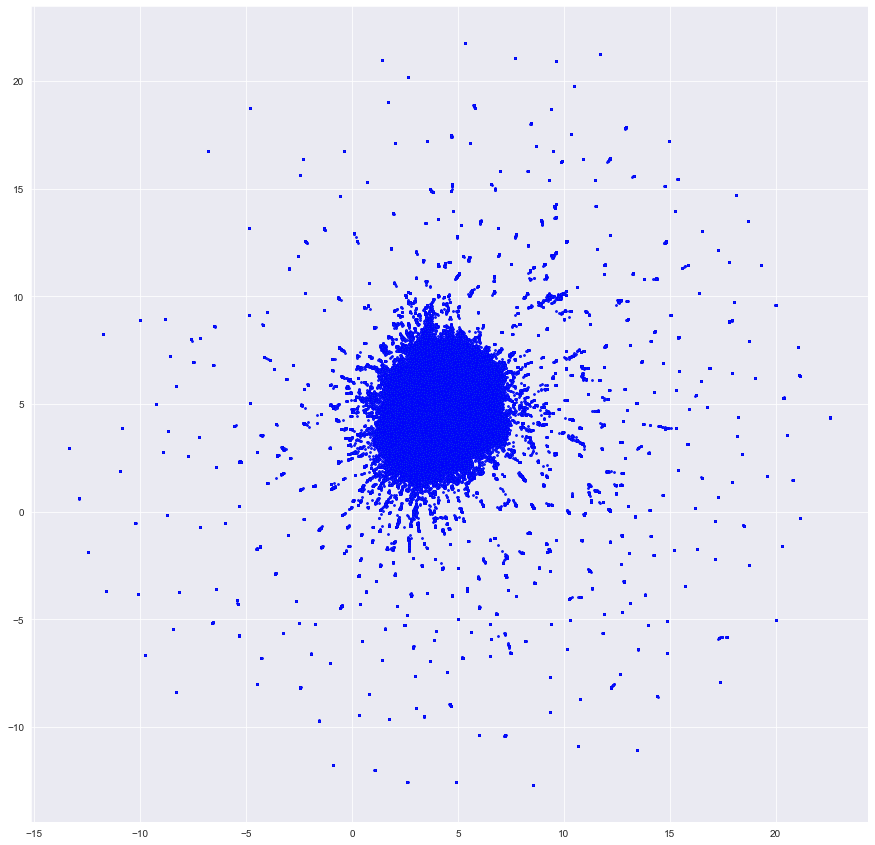

In [8]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

При помощи метода локтя определим требуемое количество кластеров. Для наших данных требуется ~10 кластеров

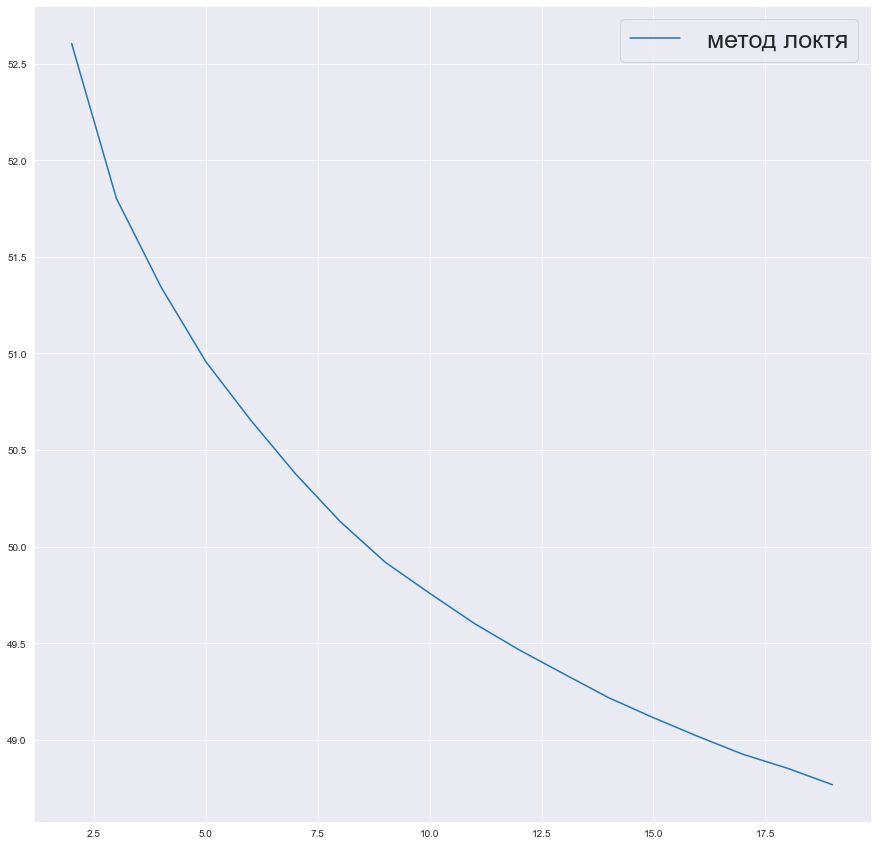

In [15]:
crit = []

x=range(2,20)
for k in x:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(w2v_vectors)
    crit.append(np.sqrt(kmeans.inertia_))

N=15
plt.figure(figsize=(N,N))
plt.plot(x,crit)
plt.legend([' метод локтя'],fontsize=25)
plt.show()

количество кластеров  2


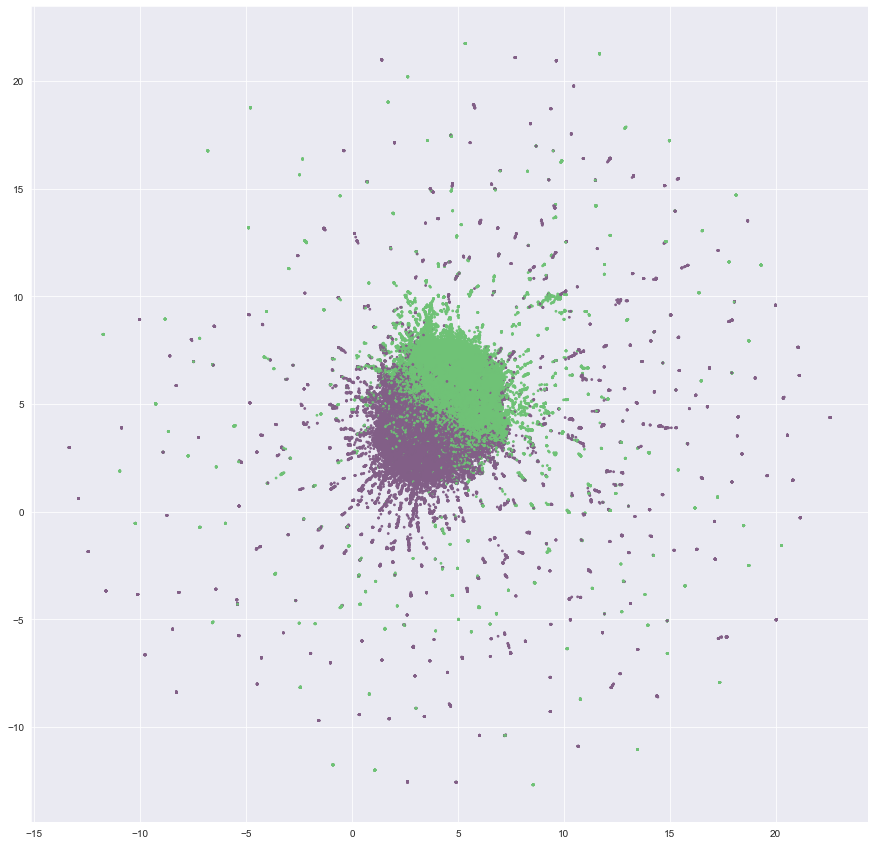

In [20]:

km_clustering = KMeans(n_clusters=2)
db_clusters = km_clustering.fit_predict(w2v_vectors)

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print('количество кластеров ',max(db_clusters)+1)
N=15
fig, ax = plt.subplots(figsize=(N,N))
#ax.set_title(signs_r[elem],fontsize=20)
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

Проверим точность кластеризации. Возьмем метрику Davies–Bouldin index

Чем дальше от 0, тем хуже кластеризация

In [16]:
davies_bouldin_score(avg_text,db_clusters)

2.5100179863286964

Выведем тексты кластеров

In [17]:
text_clusters=[]
for i,cluster in enumerate(set(db_clusters)):
    text_clusters.append([])
    for j,current_cluster in enumerate(db_clusters):
        if cluster==current_cluster:
            text_clusters[i].append(text[j])
    

In [29]:
len(text_clusters[0][:])

57917

In [30]:
for txt in text_clusters[0][:20]:
    print(txt)
    print('-----------')

Любые разногласия во мнениях скоро улягутся, а вы продолжайте делать, как делали, но постарайтесь не наступать на ноги слишком многим, иначе ваши сегодняшние действия сыграют против вас в будущем.
-----------
Первый день нового года прекрасно подходит для начинаний, которые вы постоянно откладывали в прошлом году. Отбросьте все сомнения и действуйте. Упор может быть сделан как на повышение профессиональной квалификации, так и на реформацию личной жизни.
-----------
Первый день нового года, да еще понедельник будет для вас спокойным, днем, когда вы будете сторонним наблюдателем всех событий, происходящих вокруг. Вам не придется лично принимать важные решения.
-----------
Львы не сорвутся в начале года с места в карьер, они немного устали. Первый день нового года ничем не примечателен и пройдет достаточно спокойно. Не переедайте и будьте умереннее в употреблении спиртных напитков.
-----------
Сегодняшнее расположение звезд может усилить дух соперничества, и вам лучше заняться чем-то боле

## Классификация 

In [16]:
class1 = news[news.news.str.contains("матч")]['news'].values
class2 = news[news.news.str.contains("пожар")]['news'].values
class1_tokens=processText(class1)
class2_tokens=processText(class2)
print('class 1 ',len(class1),' samples')
print('class 2 ',len(class2),' samples')

class 1  123  samples
class 2  143  samples


In [17]:
x=[]
y=[]
for i,line in enumerate(class1_tokens):
    temp=[w2v_model.wv[word] for word in line]
    mean=sum(temp)/len(temp)
    x.append(mean)
    y.append(0)
    
for i,line in enumerate(class2_tokens):
    temp=[w2v_model.wv[word] for word in line]
    mean=sum(temp)/len(temp)
    x.append(mean)
    y.append(1)
    
x=np.array(x).reshape((-1,300))
y=np.array(y).reshape((-1))

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [18]:
logreg = LogisticRegression()
res=logreg.fit(x_train, y_train)


## Проверка модели

In [19]:
predict_train=logreg.predict(x_train)
predict_test=logreg.predict(x_test)

train_score=f1_score(predict_train,y_train)
test_score=f1_score(predict_test,y_test)

print('train f1 ',train_score)
print('test f1 ',test_score)

train f1  1.0
test f1  0.96


In [20]:
cm_train=confusion_matrix(y_train,predict_train,normalize='true')
cm_test=confusion_matrix(y_test,predict_test,normalize='true')
print('True positive    False positive \nFalse negative     True negative\n')
print('матрица ошибок train\n',cm_train)
print('матрица ошибок test\n',cm_test)

True positive    False positive 
False negative     True negative

матрица ошибок train
 [[1. 0.]
 [0. 1.]]
матрица ошибок test
 [[0.93333333 0.06666667]
 [0.04       0.96      ]]
